
 Before Traffic Impact
Traffic on A → C & A → B: 6 vehicles, time: 16.6 min, α: 0.75
Chosen path before traffic: A → C → F → E
Total travel time before traffic: 25.6 min


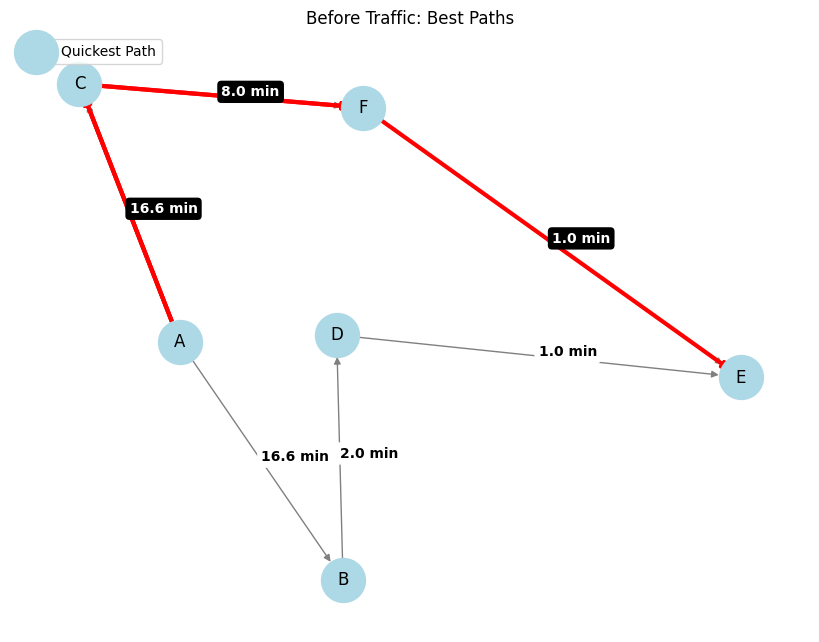


 After Traffic Impact
Traffic on A → C & A → B: 12 vehicles, time: 55.1 min, α: 1.45
Chosen path after traffic: A → B → D → E
Total travel time after traffic: 58.1 min

 Route changed! New quickest path is: A → B → D → E


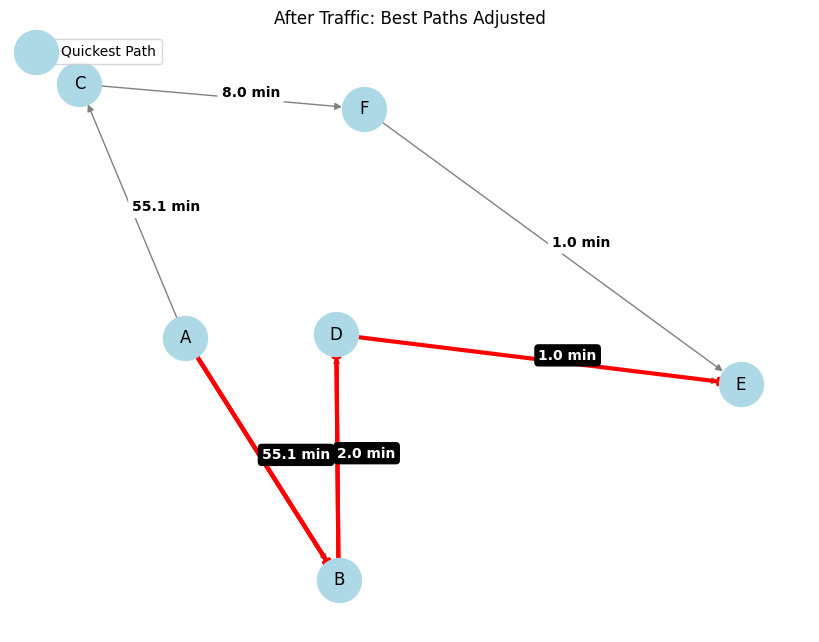

In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import poisson
import random

def create_graph():
    G = nx.DiGraph()
    G.add_weighted_edges_from([
        ("A", "B", 5),
        ("A", "C", 5),
        ("B", "D", 2),
        ("D", "E", 1),
        ("C", "F", 8),
        ("F", "E", 1)
    ])
    return G

def adjust_travel_time(base_time, num_vehicles, alpha):
    return base_time * (1 + alpha * num_vehicles)

def dijkstra(G, source):
    times = {}
    paths = {}
    queue = [(0, source, [])]

    while queue:
        queue.sort()
        current_time, node, path = queue.pop(0)

        if node in times:
            continue

        times[node] = current_time
        paths[node] = path + [node]

        neighbors = list(G[node].items())
        neighbors.sort(key=lambda x: x[1]['weight'])

        min_weight = neighbors[0][1]['weight'] if neighbors else None
        min_neighbors = [n for n in neighbors if n[1]['weight'] == min_weight]
        chosen_neighbor = random.choice(min_neighbors) if min_neighbors else None

        if chosen_neighbor:
            new_time = current_time + chosen_neighbor[1]['weight']
            queue.append((new_time, chosen_neighbor[0], paths[node]))

    return times, paths

def visualize_graph(G, paths, adjusted_weights, title):
    plt.figure(figsize=(8, 6))
    pos = nx.spring_layout(G, seed=42)

    nx.draw(G, pos, with_labels=True, node_size=1000, node_color='lightblue', font_size=12, edge_color='gray')

    edge_labels = {edge: f"{adjusted_weights[edge]:.1f} min" for edge in G.edges}

    selected_edges = []
    for node in paths:
        if node != "A":
            path_edges = list(zip(paths[node], paths[node][1:]))
            selected_edges.extend(path_edges)
            nx.draw_networkx_edges(G, pos, edgelist=path_edges, width=3, edge_color="red")

    for edge, label in edge_labels.items():
        color = "white" if edge in selected_edges else "black"
        plt.text((pos[edge[0]][0] + pos[edge[1]][0]) / 2,
                 (pos[edge[0]][1] + pos[edge[1]][1]) / 2,
                 label,
                 fontsize=10, fontweight='bold', color=color,
                 bbox=dict(facecolor='black' if color == 'white' else 'white', edgecolor='none', boxstyle='round,pad=0.3'))

    plt.title(title)
    plt.legend(["Quickest Path"], loc="upper left")
    plt.show()

def update_edge_weight(G, u, v, new_weight):
    G[u][v]['weight'] = new_weight

G = create_graph()

lambda_rate = 1.5
time_period = 5
base_time = 3
initial_vehicles = 6

def determine_alpha(vehicles):
    if vehicles < 5:
        return np.random.uniform(0.1, 0.5)
    elif 5 <= vehicles <= 10:
        return np.random.uniform(0.5, 1.0)
    else:
        return np.random.uniform(1.0, 2.0)

alpha = determine_alpha(initial_vehicles)

adjusted_time = adjust_travel_time(base_time, initial_vehicles, alpha)
update_edge_weight(G, "A", "C", adjusted_time)
update_edge_weight(G, "A", "B", adjusted_time)

times_no_traffic, paths_no_traffic = dijkstra(G, "A")

print(f"\n Before Traffic Impact")
print(f"Traffic on A → C & A → B: {initial_vehicles} vehicles, time: {adjusted_time:.1f} min, α: {alpha:.2f}")
print(f"Chosen path before traffic: {' → '.join(paths_no_traffic['E'])}")
print(f"Total travel time before traffic: {times_no_traffic['E']:.1f} min")

visualize_graph(G, paths_no_traffic, nx.get_edge_attributes(G, 'weight'), "Before Traffic: Best Paths")

new_vehicles = np.random.poisson(lambda_rate * time_period)
new_alpha = determine_alpha(new_vehicles)
updated_time = adjust_travel_time(base_time, new_vehicles, new_alpha)

update_edge_weight(G, "A", "C", updated_time)
update_edge_weight(G, "A", "B", updated_time)

times_with_traffic, paths_with_traffic = dijkstra(G, "A")

print(f"\n After Traffic Impact")
print(f"Traffic on A → C & A → B: {new_vehicles} vehicles, time: {updated_time:.1f} min, α: {new_alpha:.2f}")
print(f"Chosen path after traffic: {' → '.join(paths_with_traffic['E'])}")
print(f"Total travel time after traffic: {times_with_traffic['E']:.1f} min")

if paths_no_traffic.get("E") == paths_with_traffic.get("E"):
    print("\n Route remains the same: A → E is still quickest.")
else:
    print("\n Route changed! New quickest path is:", " → ".join(paths_with_traffic["E"]))

visualize_graph(G, paths_with_traffic, nx.get_edge_attributes(G, 'weight'), "After Traffic: Best Paths Adjusted")